In [7]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

import utils

plt.rcParams['figure.figsize'] = (17, 5)

# Load metadata and features.
tracks = utils.load('fma_metadata/tracks.csv')
genres = utils.load('fma_metadata/genres.csv')
features = utils.load('fma_metadata/features.csv')
echonest = utils.load('fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [8]:
genre_dict = {
    'Hip-Hop': 0,
    'Pop': 1,
    'Folk': 2,
    'Rock': 3,
    'Experimental': 4,
    'International': 5,
    'Electronic': 6,
    'Instrumental': 7,
}

inv_genre_dict = {v: k for k, v in genre_dict.items()}

genre_names = [inv_genre_dict[i] for i in range(8)]

((8000, 2), (8000,))

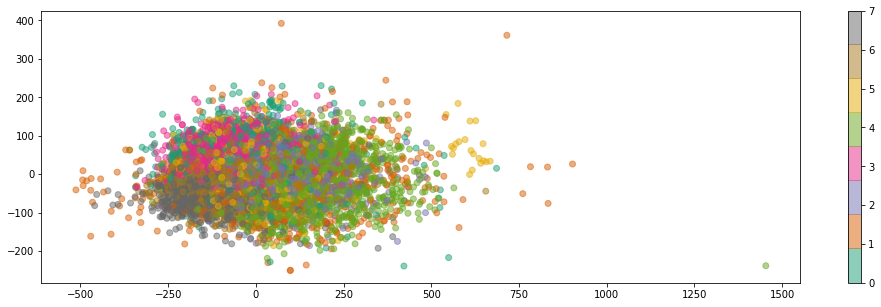

In [9]:
genre1 = tracks['track', 'genre_top'] == 'Rock'
genre2 = tracks['track', 'genre_top'] == 'Electronic'

small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'


X = features.loc[small, 'mfcc']
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

y = tracks.loc[small, ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='Dark2', alpha=0.5)
plt.colorbar()
X.shape, y.shape

In [48]:
train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
y_val = tracks.loc[small & val, ('track', 'genre_top')]
X_train = features.loc[small & train]
X_test = features.loc[small & test]
X_val = features.loc[small & val]

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

6400 training examples, 800 testing examples
518 features, 8 classes


In [11]:
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=34)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[ 0.1253238 ,  0.59807614, -0.10177305, ..., -0.10643952,
        -0.8105098 , -0.84468934],
       [-0.34768999, -0.35213792, -0.0645586 , ..., -0.51699423,
        -0.23005883,  1.11347606],
       [-0.0231874 , -0.03538058, -0.03524516, ..., -0.51699423,
         0.08205794,  0.54353052],
       ...,
       [-0.47744417, -0.39346363, -0.15097715, ..., -0.31171687,
         0.04967999,  2.57694115],
       [-0.52918994, -0.47181669, -0.1345473 , ..., -0.10643952,
         1.22919953,  1.71213092],
       [-0.46718922, -0.3620704 , -0.06173892, ...,  1.33050197,
        -0.01398353,  3.47595249]])

In [12]:
from sklearn.metrics import confusion_matrix
import itertools

def train_model(model):
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print('Accuracy: {:.2%}'.format(score))
    
def draw_cm(model, filename):
    y_predict = model.predict(X_test)
    cm = confusion_matrix(y_test, y_predict)
    print(cm)
    
    df_cm = pd.DataFrame(cm, index = [i for i in genre_names],
                      columns = [i for i in genre_names])
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    cax = ax.matshow(df_cm, cmap='hot')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(8))
    ax.set_yticks(np.arange(8))
    ax.set_xticklabels(genre_names)
    ax.set_yticklabels(genre_names)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

Accuracy: 47.88%
[[60  9  0  9  6  3  6  7]
 [ 9 43 10  1 18  2  8  9]
 [ 0 23 25  0 11 12 16 13]
 [13  4  0 72  3  5  1  2]
 [ 2 24 26  1 38  1  5  3]
 [ 5  3 28  6  3 41 11  3]
 [14  3  9 13  6  7 41  7]
 [ 0 12  3  4  8  0 10 63]]


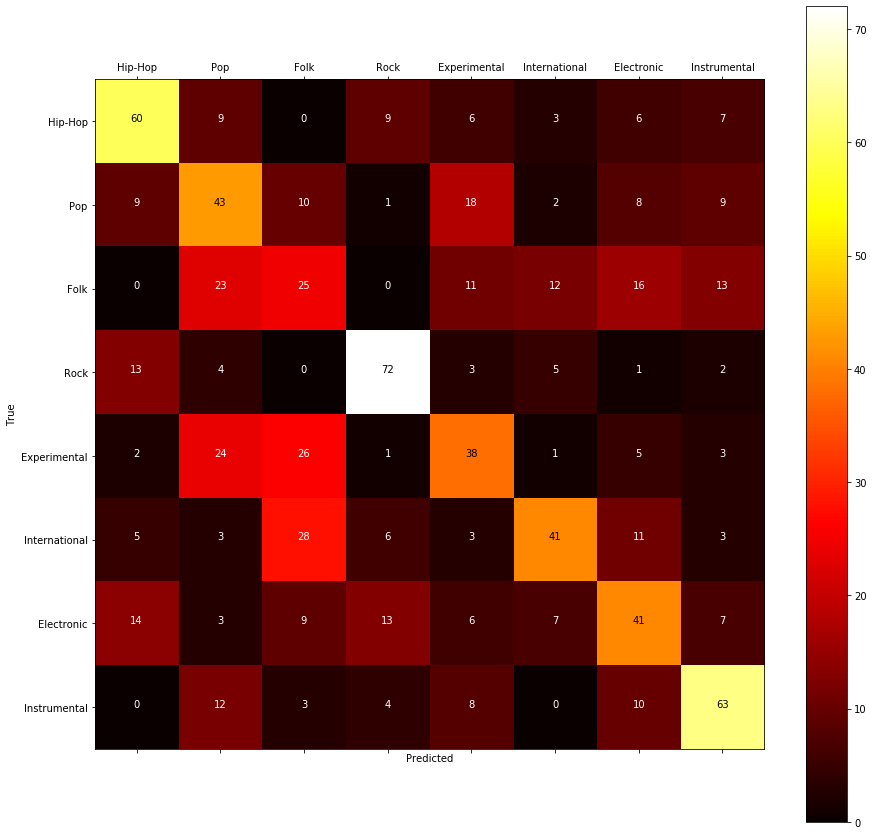

In [49]:
# Support vector classification.
svc = skl.svm.SVC()
train_model(svc)
draw_cm(svc,'baseline_scv_cm.png')

Accuracy: 40.00%
[[45 21  0  9  5  4  7  9]
 [10 32 14  2 14  8 11  9]
 [ 2 28 31  1  5 10 21  2]
 [ 9  8  2 63  0 10  1  7]
 [ 3 12 31  2 36  2 11  3]
 [ 6  6 26  4  6 37 12  3]
 [17 12  4 10  7  9 25 16]
 [ 4 15  7  2  1  5 15 51]]


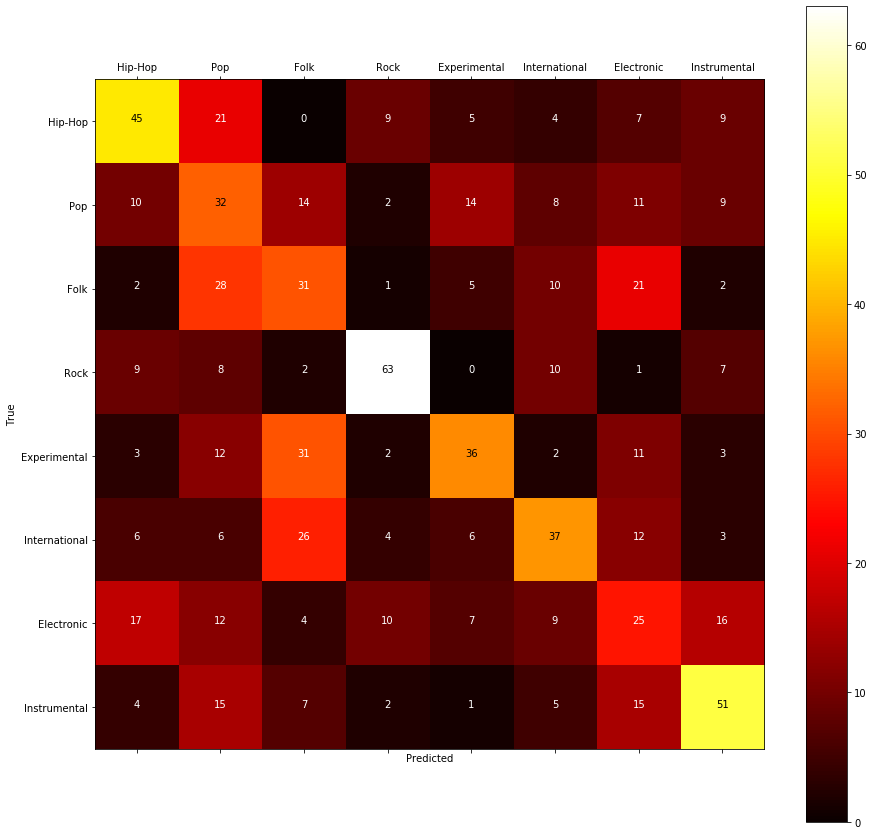

In [50]:
# Perceptron classification.
per = skl.linear_model.Perceptron(tol=1e-9, random_state=532)
train_model(per)
draw_cm(per,'baseline_perceptron_cm.png')

Accuracy: 39.62%
[[45  2  0 26  7  4 11  5]
 [16 14 21  2 15 10  7 15]
 [ 0 26 28  0 15 10  6 15]
 [15  3  1 63  2  4  0 12]
 [ 1  9 47  1 33  3  2  4]
 [ 8  4 32  9  0 31  9  7]
 [15  5  7 11 12 16 30  4]
 [ 1  7  2  1  6  2  8 73]]


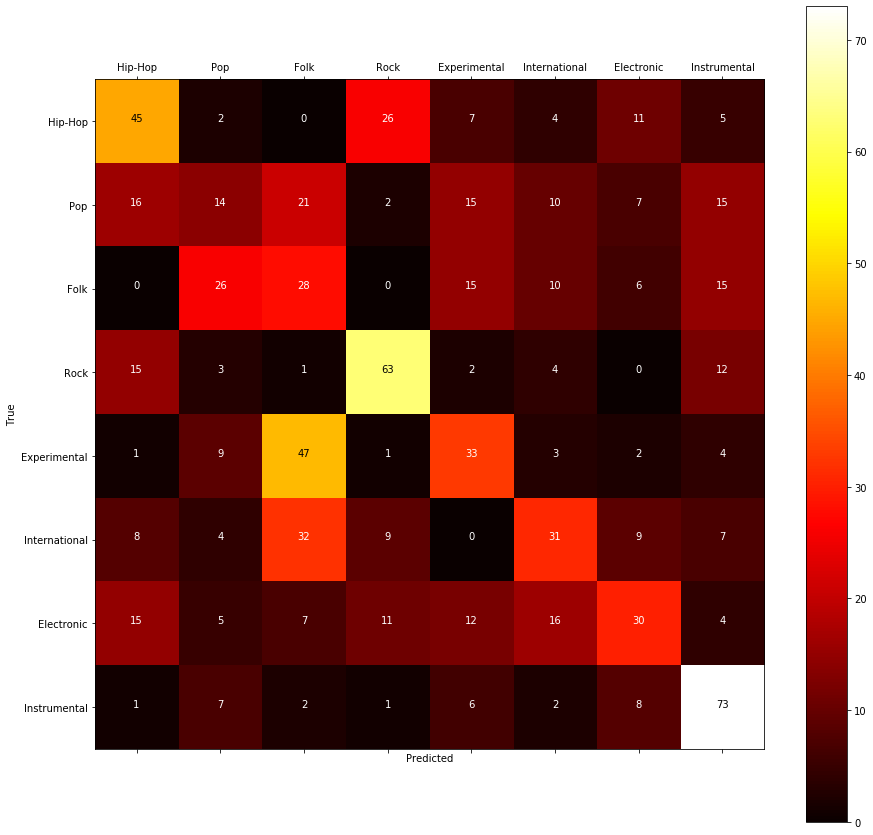

In [51]:
# Nearest centroid classification.
nei = skl.neighbors.NearestCentroid()
train_model(nei)
draw_cm(nei,'baseline_nearest_centroid_cm.png')

Accuracy: 29.25%
[[35 16  5 15  9  9  6  5]
 [ 9 22 12  9 16  7 12 13]
 [ 7 18 16  4 18 11 10 16]
 [14  7  2 38  1 17 12  9]
 [ 5 17 19  4 30  8 10  7]
 [ 9 19 11  6  2 37 10  6]
 [17  9 17  8  5 16 21  7]
 [ 5  9  7  9 15  3 17 35]]


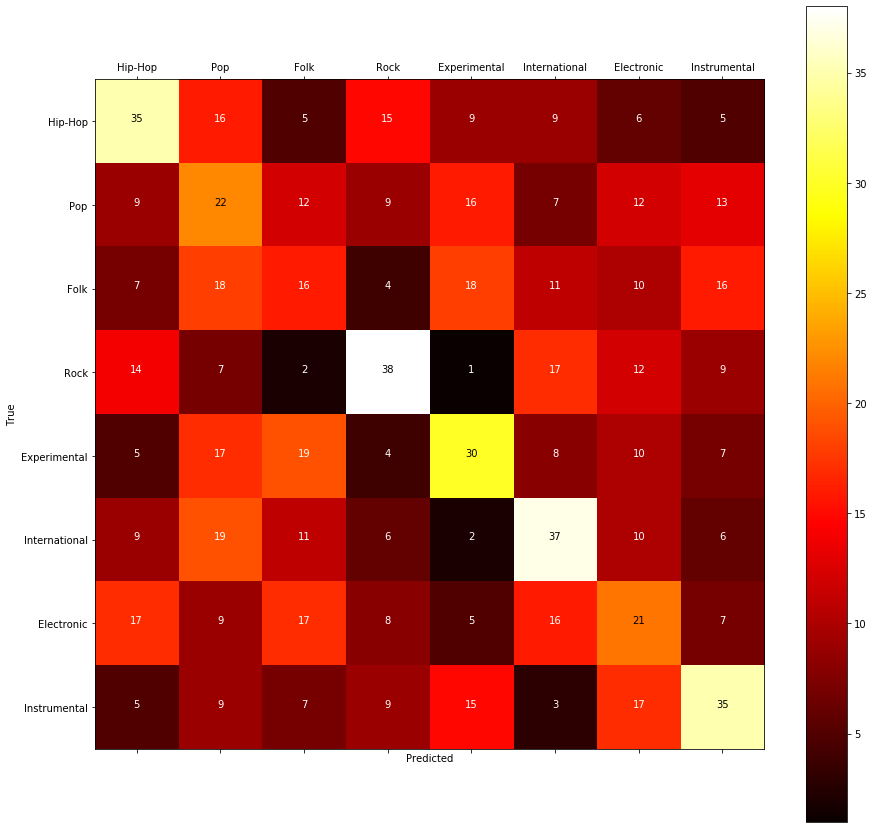

In [52]:
# Decision tree classification.
dtc = skl.tree.DecisionTreeClassifier()
train_model(dtc)
draw_cm(dtc,'baseline_decision_tree_cm.png')

Accuracy: 43.25%
[[48 10  2  8  6  3 13 10]
 [ 8 38  9  1 14  4 13 13]
 [ 0 29 28  0  5  8 19 11]
 [11  4  2 63  1  3 12  4]
 [ 4 11 21  1 45  2 14  2]
 [ 3  9 19  4  2 46 16  1]
 [13 11 15  6  9  4 35  7]
 [ 4 13  8  2  9  4 17 43]]


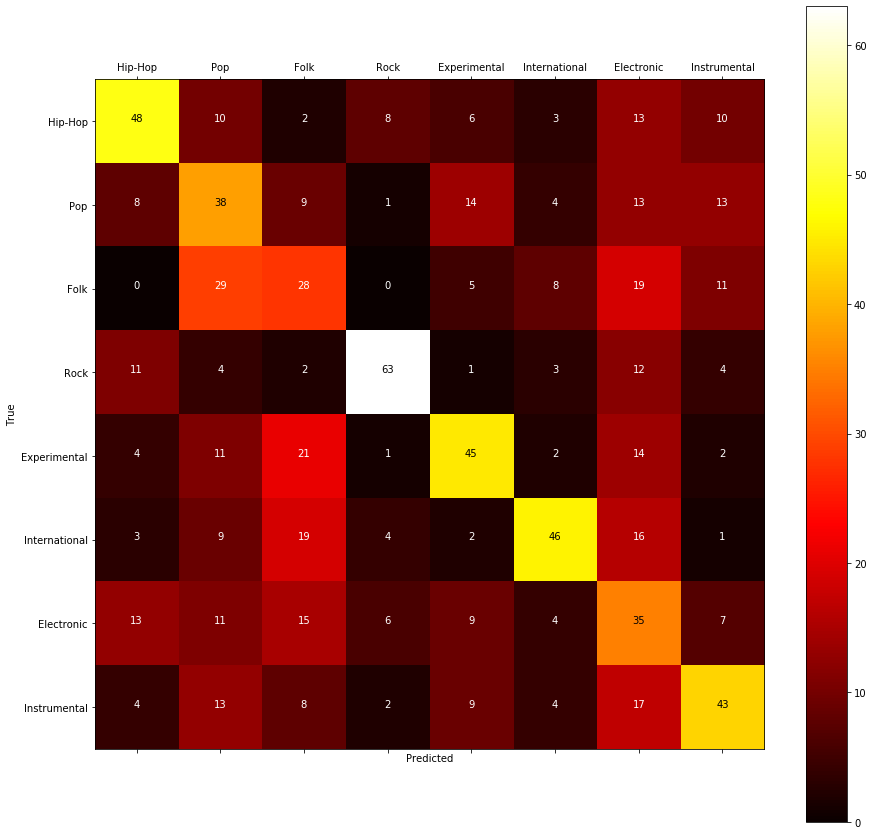

In [53]:
# NN classification.
from sklearn.neural_network import MLPClassifier                                       
mlp_1 = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=1000,
                   hidden_layer_sizes=(256, 128, 64, 8), random_state=532)
train_model(mlp_1)
draw_cm(mlp_1,'baseline_mlp_lbfgs_cm.png')

Accuracy: 41.38%
[[53  7  0 13  8  2  9  8]
 [12 45 10  2 13  2 12  4]
 [ 4 38 13  0  9 16 12  8]
 [16  2  1 67  2  4  8  0]
 [ 6 19 23  0 35  3 10  4]
 [ 6 10 16  3  4 49 10  2]
 [19 11 10  7  6 10 32  5]
 [ 5 13 11  1  5  4 24 37]]


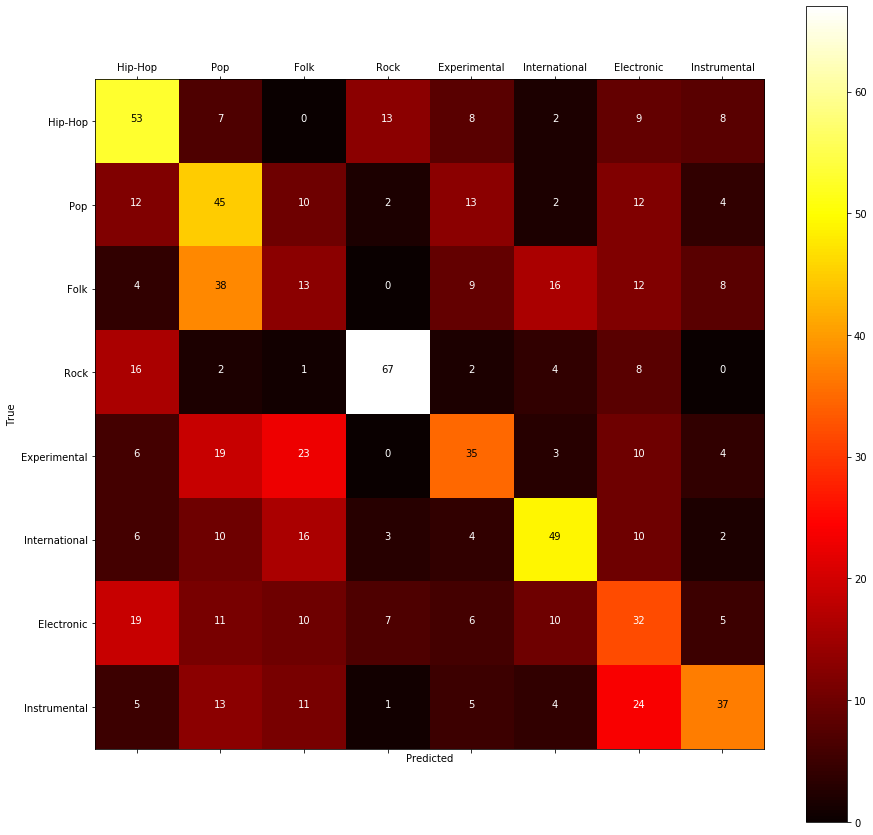

In [54]:
mlp_2 = MLPClassifier(solver='adam', alpha=1e-5, max_iter=1000, activation='relu',
                   hidden_layer_sizes=(256, 128, 64, 8), random_state=532)
train_model(mlp_2)
draw_cm(mlp_2,'baseline_mlp_adam_cm.png')

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.optimizers import RMSprop, Nadam

import keras

In [44]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))

model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(8, activation='softmax'))

model.compile(optimizer='RMSprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               66432     
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_20 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 8)                

In [50]:
epochs = 100
batch_size = 64
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [52]:
tb_hist = keras.callbacks.TensorBoard(log_dir='.', histogram_freq=0, write_graph=True, write_images=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2)
hist = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_data= (X_val, y_val),) 


Train on 6400 samples, validate on 800 samples
Epoch 1/100
  64/6400 [..............................] - ETA: 42s

UnimplementedError:  Cast string to int64 is not supported
	 [[node loss/dense_28_loss/Cast (defined at <ipython-input-52-314494efe157>:3) ]] [Op:__inference_distributed_function_7717]

Function call stack:
distributed_function
